In [7]:
import copy
import igraph
from igraph import Graph
import matplotlib.pyplot as plt
import numpy as np

from scipy.special import softmax
import time

import data_handler as dh
from utils import find_all_paths, calculate_new_cost, get_path_cost, get_gumbel_values


# Braess example

In [10]:
net_name = 'data/Braess_net.tntp'
trips_name = 'data/Braess_trips.tntp'

N = 10000

In [11]:
handler = dh.DataHandler() 
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time', 'b', 'power'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

graph_data['graph_table'].head()


,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time,b,power
0,1,True,3,True,1.0,1.000000e-08,1.000000e+09,1.0
1,1,True,4,True,1.0,5.000000e+01,2.000000e-02,1.0
2,3,True,2,True,1.0,5.000000e+01,2.000000e-02,1.0
3,3,True,4,True,1.0,1.000000e+01,1.000000e-01,1.0
4,4,True,2,True,1.0,1.000000e-08,1.000000e+09,1.0


In [12]:
gr = graph_data['graph_table']

## Start point

In [13]:
gr['flow'] = 0
gr.loc[0, ['flow']] =  N 
gr.loc[2, ['flow']] =  N
gr['cost'] = 0.


In [14]:
gr.head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time,b,power,flow,cost
0,1,True,3,True,1.0,1.000000e-08,1.000000e+09,1.0,10000,0.0
1,1,True,4,True,1.0,5.000000e+01,2.000000e-02,1.0,0,0.0
2,3,True,2,True,1.0,5.000000e+01,2.000000e-02,1.0,10000,0.0
3,3,True,4,True,1.0,1.000000e+01,1.000000e-01,1.0,0,0.0
4,4,True,2,True,1.0,1.000000e-08,1.000000e+09,1.0,0,0.0


In [15]:
gr.loc[0, 'free_flow_time'] = 0.001
gr.loc[1, 'free_flow_time'] = 45.
gr.loc[2, 'free_flow_time'] = 45.
gr.loc[3, 'free_flow_time'] = 0.00001
gr.loc[4, 'free_flow_time'] = 0.001


gr.loc[0, 'b'] = 1.
gr.loc[1, 'b'] = 0. 
gr.loc[2, 'b'] = 0.
gr.loc[3, 'b'] = 0.
gr.loc[4, 'b'] = 1.


gr.loc[0, 'capacity'] = 100.
gr.loc[1, 'capacity'] = 1
gr.loc[2, 'capacity'] = 1
gr.loc[3, 'capacity'] = 1
gr.loc[4, 'capacity'] = 100

In [16]:
gr = calculate_new_cost(gr)

In [17]:
g = Graph(n=4, edges = gr.loc[:, ['init_node', 'term_node']].values, directed= True)

In [18]:
all_paths = find_all_paths(g, 1, 2)

In [19]:
all_cars = np.arange(N)[:, None]

all_cars = np.hstack((all_cars, [[0] for x in range(N)]))

In [20]:
paths_quantity = len(all_paths)

In [21]:
path_length = []
for i, x in enumerate(all_paths, 0):
    print(get_path_cost(x, gr))
    path_length.append(get_path_cost(x, gr))
    
path_length = np.array(path_length)

path_length

145.001
100.00201000000001
45.001


array([145.001  , 100.00201,  45.001  ])

In [22]:
gr

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time,b,power,flow,cost
0,1,True,3,True,100.0,0.00100,1.0,1.0,10000,100.00100
1,1,True,4,True,1.0,45.00000,0.0,1.0,0,45.00000
2,3,True,2,True,1.0,45.00000,0.0,1.0,10000,45.00000
3,3,True,4,True,1.0,0.00001,0.0,1.0,0,0.00001
4,4,True,2,True,100.0,0.00100,1.0,1.0,0,0.00100


# One step of logit dynamics

In [35]:
def draw_plot(steps_first_gamma, n_list, time_step_size, gamma):
    steps_first_gamma = np.array(steps_first_gamma)

    plt.figure(figsize = (10, 6))
    x = np.log(n_list)
    y = steps_first_gamma * time_step_size


    plt.plot(x, y,'o', markersize=10)

    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]

    plt.plot(x, m*x + c, 'r')
    plt.grid()

    plt.legend()
    plt.title(f'$\gamma = {gamma}$', fontsize=16)
    plt.xlabel('$\log (N)$', fontsize=16)
    plt.ylabel('$T_{mix}$', fontsize=16)
    #plt.show()

    plt.savefig(f'logit_{gamma}_0_1.jpg')

Step: [1/8]
####################################################################################################
####################################################################################################
[46.281    1.28201 45.001  ]
0.0
[46.281    1.28201 45.001  ]
0.0
[46.281    1.28201 45.001  ]
0.0
[46.281    1.32201 45.041  ]
0.031201004672350482
[46.281    1.32201 45.041  ]
0.009160235418050253
[46.281    1.36201 45.081  ]
0.033070137514126935
[46.281    1.36201 45.081  ]
0.009696574321869912
[46.281    1.36201 45.081  ]
0.0028893604675992823
[46.281    1.36201 45.081  ]
0.0008650585141687506
[46.281    1.36201 45.081  ]
0.00025936050084393033
[46.281    1.37201 45.091  ]
0.0074204551966485285
[46.281    1.37201 45.091  ]
0.0022146330492711975
[46.281    1.40201 45.121  ]
0.022543596269011482
[46.281    1.40201 45.121  ]
0.006658012006463862
[46.281    1.42201 45.141  ]
0.016281732405087044
[46.281    1.44201 45.161  ]
0.018962000503171438
[46.281    1.45201 45.171  ]
0.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[127.281   163.84201 126.561  ]
0.004135041506745648
####################################################################################################
####################################################################################################
Step: [1/8]
####################################################################################################
####################################################################################################
[46.281    1.28201 45.001  ]
0.0
[46.281    1.28201 45.001  ]
0.0
[46.281    1.29201 45.011  ]
0.0078002511680876204
[46.281    1.33201 45.051  ]
0.033358934375994104
[46.281    1.34201 45.061  ]
0.017360189824957847
[46.281    1.38201 45.101  ]
0.03510493281603425
[46.281    1.39201 45.111  ]
0.01758910602661365
[46.281    1.40201 45.121  ]
0.01243385557553539
[46.281    1.42201 45.141  ]
0.01801595655052545
[46.281    1.42201 45.141  ]
0.005337475160747789
[46.281    1.42201 45.141  ]
0.0015952822028319847
[46.281    1.4420

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[127.381   163.84201 126.461  ]
0.004954855840707847
####################################################################################################
####################################################################################################
Step: [1/8]
####################################################################################################
####################################################################################################
[46.281    1.29201 45.011  ]
0.0078002511680876204
[46.281    1.31201 45.031  ]
0.01784315094529921
[46.281    1.32201 45.041  ]
0.012949100075855782
[46.281    1.33201 45.051  ]
0.011443194071104335
[46.281    1.34201 45.061  ]
0.010938697043817317
[46.281    1.34201 45.061  ]
0.003256672485561831
[46.281    1.34201 45.061  ]
0.0009747795692067497
[46.281    1.34201 45.061  ]
0.0002922344658312945
[46.281    1.35201 45.071  ]
0.007539814855162922
[46.281    1.35201 45.071  ]
0.0022500688845880994
[46.281    1.37201 45.091  ]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[127.461   163.84201 126.381  ]
0.004464171178649266
####################################################################################################
####################################################################################################


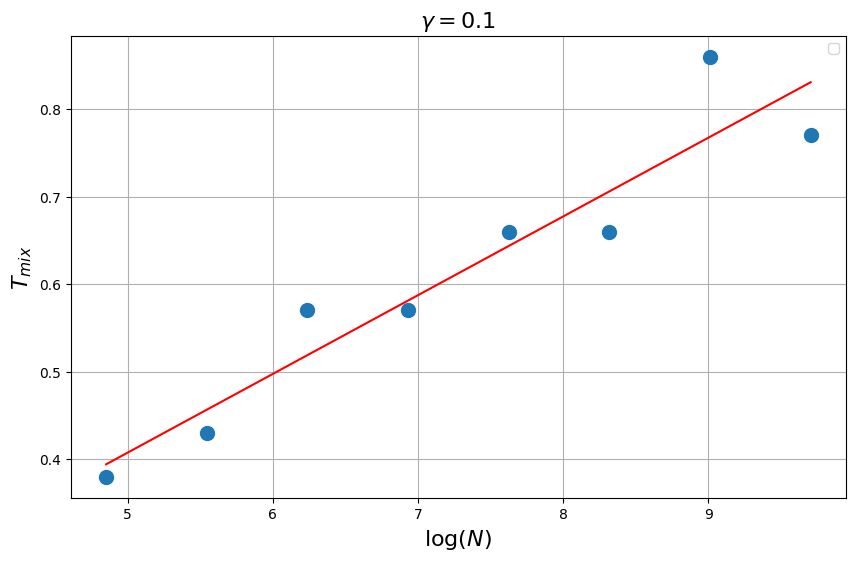

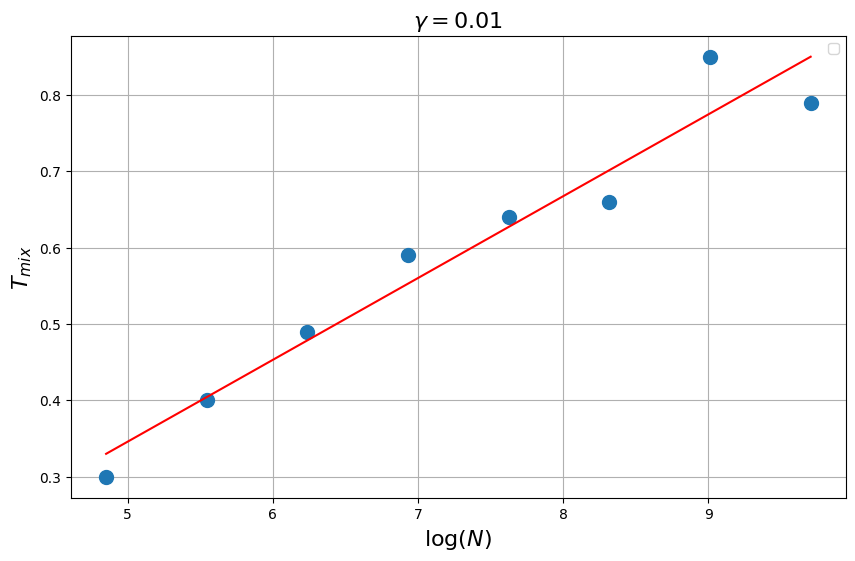

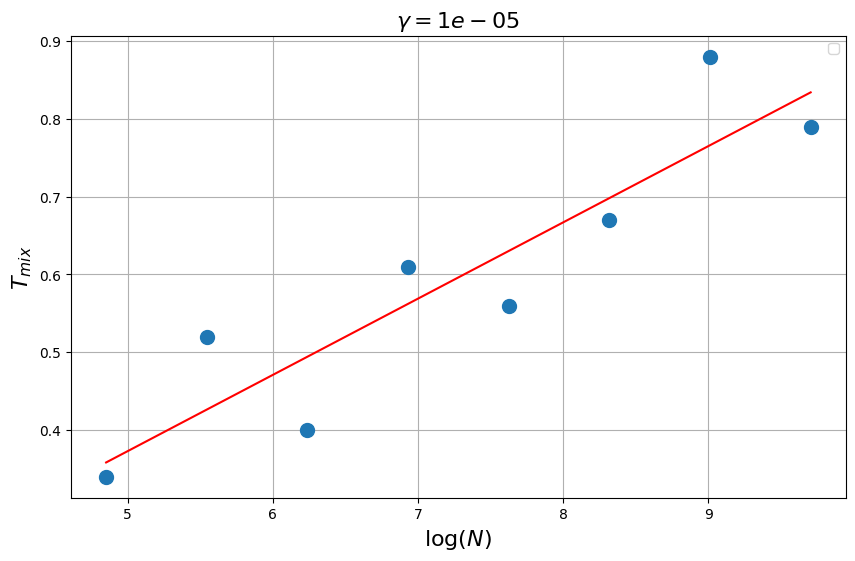

In [44]:
for gamma in [0.1, 0.01, 0.00001]:
    NUM_EPOCHS = 2000
    lambda_poisson = 1.0
    EPS = 5e-3

    time_list = []

    n_list = np.array([2**x for x in range(7, 15)])

    steps_first_gamma = []
    for q, N in enumerate(n_list):


        time_step_size = 0.01#(N * lambda_poisson)**-1

        print(f"Step: [{q + 1}/{len(n_list)}]")
        print('#' * 100)
        print('#' * 100)
        gr['flow'] = 0
        gr.loc[0, ['flow']] = N
        gr.loc[2, ['flow']] = N
        gr['cost'] = 0.
        gr = calculate_new_cost(gr)
        start_time = time.time()


        all_cars = np.arange(N)[:, None]
        all_cars = np.hstack((all_cars, [[0] for x in range(N)]))

        tmp_gr_matrix = gr.copy()
        path_length = []
        for i, x in enumerate(all_paths, 0):
            path_length.append(get_path_cost(x, gr))
        
        path_length = np.array(path_length)

        new_flow = {0: N, 1: 0, 2:0}


        num_steps_first_gamma = 0

        mean_path_length = copy.deepcopy(path_length)
        tolerance = 5
        tolerance_count = 0
        for j in range(NUM_EPOCHS):
            
            num_steps_first_gamma += 1
            tmp_gr_matrix = tmp_gr_matrix.copy()    

            for i, x in enumerate(all_cars, 0):
                # noise_vector = np.random.normal(0., 100., size = paths_quantity)
                gumbel_values = get_gumbel_values(paths_quantity, gamma=gamma)
                tmp_path_length = -path_length + gumbel_values# + noise_vector

                probs = softmax(tmp_path_length / gamma)

                new_path = np.random.choice(len(probs), None, p=probs)
                change_route = np.random.binomial(1, time_step_size * lambda_poisson)

                if change_route == 1:
                    new_flow[x[1]] = new_flow[x[1]] - 1
                    new_flow[new_path] = new_flow[new_path] + 1
                    all_cars[i][1] = new_path

            tmp_gr_matrix.loc[:, 'flow'] = 0
            for x in new_flow.keys():
                for i, y in enumerate(all_paths[x], 0):
                    if i + 1 != len(all_paths[x]):
                        tmp_gr_matrix.loc[(tmp_gr_matrix.init_node == all_paths[x][i]) & (tmp_gr_matrix.term_node == all_paths[x][i + 1]), 'flow'] += new_flow[x] 

            tmp_gr_matrix = calculate_new_cost(tmp_gr_matrix)
            path_length_prev = copy.deepcopy(path_length)
            path_length = []
            for i, x in enumerate(all_paths, 0):
                path_length.append(get_path_cost(x, tmp_gr_matrix))
            
            path_length = np.array(path_length)
            print(path_length)
            error = np.max(np.abs(mean_path_length - path_length) / np.abs(mean_path_length))
            print(error)
            if j > 10 and error < EPS:
                tolerance_count +=1
            if tolerance_count > tolerance:
                break 
            alpha = 0.7
            mean_path_length = (1 - alpha) * mean_path_length + alpha * path_length
        steps_first_gamma.append(num_steps_first_gamma)
        print('#' * 100)
        print('#' * 100)
    
    draw_plot(steps_first_gamma, n_list, time_step_size, gamma)
